## MLP Mixer

by Jeremy Tan, Benjamin Ang

In [1]:
# !pip install ucimlrepo


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
# Data Handling and Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
# Dataset Fetching
from ucimlrepo import fetch_ucirepo


In [3]:
# Fetch Dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
Y = breast_cancer_wisconsin_diagnostic.data.targets

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), 
                        columns=X.columns, 
                        index=X.index)
# Assign the value of 1 to Malignant, assign 0 to Benign
Y.loc[:, 'Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


c:\users\jeremy tan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [4]:
print(f"X train shape is {X_train.shape}")
print(f"X test shape is {X_test.shape}")
print(f"Y train shape is {Y_train.shape}")
print(f"Y test shape is {Y_test.shape}")



X train shape is (455, 30)
X test shape is (114, 30)
Y train shape is (455, 1)
Y test shape is (114, 1)


In [5]:
Y.value_counts()

Diagnosis
0            357
1            212
dtype: int64

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        # Convert NumPy array to a PyTorch tensor
        self.data_x = torch.tensor(x_train, dtype=torch.float32)
        self.data_y = torch.tensor(y_train, dtype=torch.float32)

    def __len__(self):
        # Return the number of samples (n)
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        # Get the m-dimensional data point at index `idx`
        return self.data_x[idx], self.data_y[idx]

# Get the numpy values from df x and y
x_train = X_train.values.astype(np.float32)
y_train = Y_train.values.astype(np.float32)

# Create the training dataset
training_dataset = CustomDataset(x_train, y_train)

# Example usage with DataLoader
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

In [7]:
x,y = next(iter(train_loader))

In [8]:
print(x.shape)
print(y.shape)

torch.Size([32, 30])
torch.Size([32, 1])


In [11]:
import torch
import torch.nn as nn

class MLP_Mixer_Block(nn.Module):
    def __init__(self):
        super(MLP_Mixer_Block, self).__init__()
        self.token_mixing = nn.Sequential(
            nn.Linear(1, 16),
            nn.GELU(),
            nn.Linear(16, 1)
        )
        self.channel_mixing = nn.Sequential(
            nn.Linear(30, 16),
            nn.GELU(),
            nn.Linear(16, 30)
        )
        self.layer_norm1 = nn.LayerNorm(30)
        self.layer_norm2 = nn.LayerNorm(30)

    def forward(self, x):
        # x shape: [batch_size, 1, 30]
        # First layer norm
        x_norm = self.layer_norm1(x)
        
        # Transpose for token mixing
        x_mixed = x_norm.transpose(1, 2)  # [batch_size, 30, 1]
        
        # Token mixing
        x_token_mixed = self.token_mixing(x_mixed)  # [batch_size, 30, 1]
        
        # Transpose back
        x_token_mixed = x_token_mixed.transpose(1, 2)  # [batch_size, 1, 30]
        
        # Residual connection
        x = x + x_token_mixed
        
        # Second layer norm
        x_norm2 = self.layer_norm2(x)
        
        # Channel mixing
        x_channel_mixed = self.channel_mixing(x_norm2.squeeze(1)).unsqueeze(1)
        
        # Final residual connection
        x = x + x_channel_mixed
        
        return x

class MLP_Mixer(nn.Module):
    def __init__(self, num_blocks=4):
        super(MLP_Mixer, self).__init__()
        self.per_path_FC = nn.Linear(30, 30)
        self.mixer_blocks = nn.ModuleList([MLP_Mixer_Block() for _ in range(num_blocks)])
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(30, 1)

    def forward(self, x):
        # Ensure input is [batch_size, features]
        x = x.view(-1, 30)
        x = self.per_path_FC(x)
        
        # Add token dimension
        x = x.unsqueeze(1)  # [batch_size, 1, features]
        
        # Apply mixer blocks
        for block in self.mixer_blocks:
            x = block(x)
        
        # Global average pooling
        x = x.permute(0, 2, 1)  # [batch_size, features, 1]
        x = self.global_avg_pool(x)
        
        # Classification head
        x = x.view(-1, 30)
        x = self.head(x)
        
        return x

# Test the model
model = MLP_Mixer()
x = torch.rand(2, 30)
y = model(x)
print("Final output:", y)

Final output: tensor([[0.1176],
        [0.2477]], grad_fn=<AddmmBackward0>)


Epoch [1/20], Loss: 0.7065
Epoch [2/20], Loss: 0.6362
Epoch [3/20], Loss: 0.5708
Epoch [4/20], Loss: 0.5228
Epoch [5/20], Loss: 0.4624
Epoch [6/20], Loss: 0.4077
Epoch [7/20], Loss: 0.3720
Epoch [8/20], Loss: 0.3329
Epoch [9/20], Loss: 0.2930
Epoch [10/20], Loss: 0.2571
Epoch [11/20], Loss: 0.2392
Epoch [12/20], Loss: 0.2280
Epoch [13/20], Loss: 0.1932
Epoch [14/20], Loss: 0.1928
Epoch [15/20], Loss: 0.1663
Epoch [16/20], Loss: 0.1681
Epoch [17/20], Loss: 0.1674
Epoch [18/20], Loss: 0.1361
Epoch [19/20], Loss: 0.1283
Epoch [20/20], Loss: 0.1283


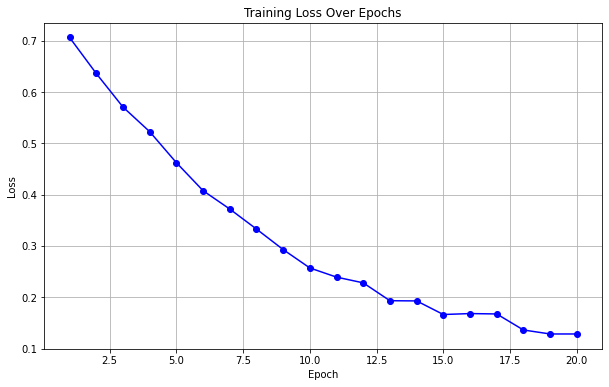

In [12]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = 20

# Define the model
# 30 input features
model = MLP_Mixer()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# List to store the loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Append the average loss to the loss_values list
    loss_values.append(avg_loss)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [13]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Convert test data to PyTorch tensors (if not already)
x_test = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test = torch.tensor(Y_test.values.astype(np.float32), dtype=torch.float32)

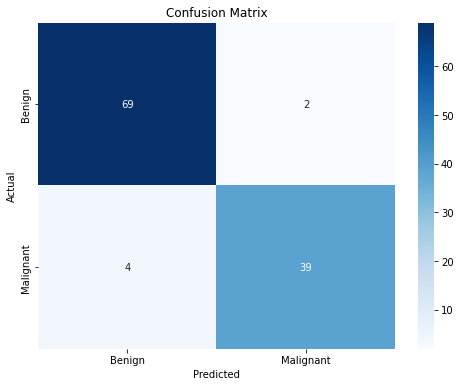

              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96        71
   Malignant       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [15]:


# Disable gradient computation for evaluation
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(x_test)
    test_predictions_binary = (test_predictions > 0.5).numpy().flatten()
    
# Convert test labels to numpy
y_test_binary = y_test.flatten()

# Create confusion matrix
cm = confusion_matrix(y_test_binary, test_predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print(classification_report(y_test_binary, test_predictions_binary, 
                             target_names=['Benign', 'Malignant']))

## Bayesian Optimization

Parameters:
1. Learning Rate
2. Number of MLP Mixer Blocks
3. Token mixing hidden dimension
4. Channel mixing hidden dimension


In [16]:
torch.manual_seed(42)
np.random.seed(42)

In [17]:
class MLP_Mixer_Block(nn.Module):
    def __init__(self, token_mix_hidden_dim, channel_mix_hidden_dim):
        super(MLP_Mixer_Block, self).__init__()
        self.token_mixing = nn.Sequential(
            nn.Linear(1, token_mix_hidden_dim),
            nn.GELU(),
            nn.Linear(token_mix_hidden_dim, 1)
        )
        self.channel_mixing = nn.Sequential(
            nn.Linear(30, channel_mix_hidden_dim),
            nn.GELU(),
            nn.Linear(channel_mix_hidden_dim, 30)
        )
        self.layer_norm1 = nn.LayerNorm(30)
        self.layer_norm2 = nn.LayerNorm(30)

    def forward(self, x):
        # x shape: [batch_size, 1, 30]
        # First layer norm
        x_norm = self.layer_norm1(x)
        
        # Transpose for token mixing
        x_mixed = x_norm.transpose(1, 2)  # [batch_size, 30, 1]
        
        # Token mixing
        x_token_mixed = self.token_mixing(x_mixed)  # [batch_size, 30, 1]
        
        # Transpose back
        x_token_mixed = x_token_mixed.transpose(1, 2)  # [batch_size, 1, 30]
        
        # Residual connection
        x = x + x_token_mixed
        
        # Second layer norm
        x_norm2 = self.layer_norm2(x)
        
        # Channel mixing
        x_channel_mixed = self.channel_mixing(x_norm2.squeeze(1)).unsqueeze(1)
        
        # Final residual connection
        x = x + x_channel_mixed
        
        return x

class MLP_Mixer(nn.Module):
    def __init__(self, num_blocks, token_mix_hidden_dim, channel_mix_hidden_dim):
        super(MLP_Mixer, self).__init__()
        self.per_path_FC = nn.Linear(30, 30)
        self.mixer_blocks = nn.ModuleList([MLP_Mixer_Block(token_mix_hidden_dim, channel_mix_hidden_dim) for _ in range(num_blocks)])
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(30, 1)

    def forward(self, x):
        # Ensure input is [batch_size, features]
        x = x.view(-1, 30)
        x = self.per_path_FC(x)
        
        # Add token dimension
        x = x.unsqueeze(1)  # [batch_size, 1, features]
        
        # Apply mixer blocks
        for block in self.mixer_blocks:
            x = block(x)
        
        # Global average pooling
        x = x.permute(0, 2, 1)  # [batch_size, features, 1]
        x = self.global_avg_pool(x)
        
        # Classification head
        x = x.view(-1, 30)
        x = self.head(x)
        
        return x

In [18]:
def objective(trial):
    # Hyperparameters to optimize
    num_blocks = trial.suggest_int('num_blocks', 1, 8)
    token_mix_hidden_dim = trial.suggest_categorical('token_mix_hidden_dim', [32, 64, 128])
    channel_mix_hidden_dim = trial.suggest_categorical('channel_mix_hidden_dim', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype = torch.float32)
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype = torch.float32)
    X_val_tensor = torch.tensor(X_val.values.astype(np.float32), dtype = torch.float32)
    y_val_tensor = torch.tensor(y_val.values.astype(np.float32), dtype = torch.float32)
    
    
    # Create model, loss, and optimizer
    model = MLP_Mixer(num_blocks, token_mix_hidden_dim, channel_mix_hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create the training dataset
    training_dataset = CustomDataset(X_train_tensor, y_train_tensor)

    # Example usage with DataLoader
    train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

    # Training
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = (val_outputs > 0.5).float()
        accuracy = accuracy_score(y_val, val_preds.numpy())
        auc = roc_auc_score(y_val, val_outputs.numpy())
    
    # Report multiple metrics
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('auc', auc)
    
    return val_loss.item()


In [19]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
Y = breast_cancer_wisconsin_diagnostic.data.targets
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), 
                        columns=X.columns, 
                        index=X.index)
# Assign the value of 1 to Malignant, assign 0 to Benign
Y.loc[:, 'Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

# Split the data - 60/20/20 Train Validation Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', 
                             study_name='MLP Mixer Optimization')
study.optimize(objective, n_trials=50)

# Print results
print("Best trial:")
trial = study.best_trial
print(f"  Value (Val Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print additional metrics from the best trial
print("\nBest Trial Metrics:")
print(f"  Accuracy: {trial.user_attrs['accuracy']}")
print(f"  AUC: {trial.user_attrs['auc']}")


c:\users\jeremy tan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
[I 2024-12-05 21:49:12,235] A new study created in memory with name: MLP Mixer Optimization
<ipython-input-18-06187830d250>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-6-1e5ce8616122>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().d

Best trial:
  Value (Val Loss): 0.0960722267627716
  Params: 
    num_blocks: 8
    token_mix_hidden_dim: 128
    channel_mix_hidden_dim: 32
    learning_rate: 0.0002383069428337443

Best Trial Metrics:
  Accuracy: 0.9824561403508771
  AUC: 0.9912337662337662


## Lastly, evaluate on the test set

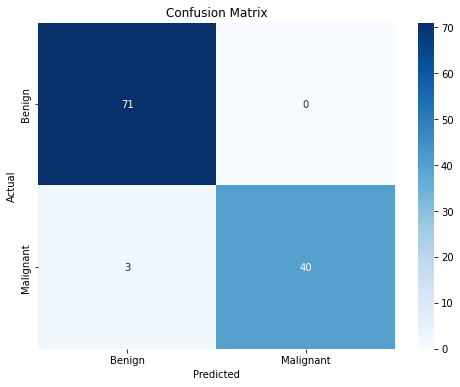

In [29]:
# Get the best trial's parameters
best_params = study.best_trial.params
best_no_of_blocks = best_params['num_blocks']
best_token_mix_hidden_dim = best_params['token_mix_hidden_dim']
best_channel_mix_hidden_dim = best_params['channel_mix_hidden_dim']
best_learning_rate = best_params['learning_rate']

best_model = MLP_Mixer(best_no_of_blocks, best_token_mix_hidden_dim, best_channel_mix_hidden_dim)

# Convert train and validation data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32)

# Create optimizer with the best learning rate
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Retrain the model with best hyperparameters
# Batching is not implemented. 
# The whole training dataset is processed in a single pass. 
num_epochs = 20
for epoch in range(num_epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32)

# Evaluate on test set
best_model.eval()
with torch.no_grad():
    # Predictions
    test_outputs = best_model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()
    
    # Calculate metrics
    test_loss = criterion(test_outputs, y_test_tensor)
    test_accuracy = accuracy_score(y_test, test_preds.numpy())
    test_auc = roc_auc_score(y_test, test_outputs.numpy())
    
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds.numpy())

# Classification Report
class_report = classification_report(y_test, test_preds.numpy())

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
# Print results
print("\nTest Set Evaluation:")
print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(class_report)


Test Set Evaluation:
Test Loss: 0.24762921035289764
Test Accuracy: 0.9736842105263158
Test AUC: 0.9954143465443827

Confusion Matrix:
[[71  0]
 [ 3 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

